In [1]:
import os
import random
import numpy as np
import pandas as pd
from PIL import Image as PILImage
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, RMSprop
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D , MaxPool2D, Flatten, Dense
from tensorflow.keras import datasets, layers, models
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, Callback
from tensorflow.keras.applications.vgg19 import VGG19
import random
import numpy as np
import pandas as pd
# from PIL import Image
import matplotlib.pyplot as plt
# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
train_ds = tf.keras.utils.image_dataset_from_directory("/kaggle/input/cs671-assignment5/Group_18/train", image_size=(224,224),batch_size=1, seed = 42)
val_ds = tf.keras.utils.image_dataset_from_directory("/kaggle/input/cs671-assignment5/Group_18/val", image_size=(224,224),batch_size=1, seed = 42)
test_ds = tf.keras.utils.image_dataset_from_directory("/kaggle/input/cs671-assignment5/Group_18/test", image_size=(224,224),batch_size=1, seed = 42)
class_names = train_ds.class_names

Found 250 files belonging to 5 classes.
Found 50 files belonging to 5 classes.
Found 100 files belonging to 5 classes.


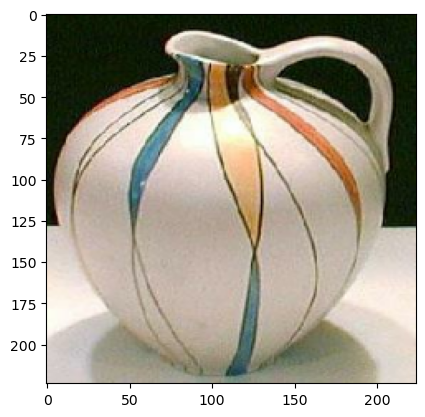

In [3]:
for x,y in test_ds:
    plt.imshow((x[0].numpy()).astype("uint8"))
    plt.show()
    break

In [4]:
%%script echo skip
train_ds = train_ds.map(lambda x, y: (tf.keras.applications.vgg19.preprocess_input(x), y))
val_ds = val_ds.map(lambda x, y: (tf.keras.applications.vgg19.preprocess_input(x), y))
test_ds = test_ds.map(lambda x, y: (tf.keras.applications.vgg19.preprocess_input(x), y))

skip


In [5]:
%%script echo skip
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

skip


In [6]:
vgg19 = VGG19(weights='imagenet', include_top=True)

574710816/574710816 [==============================] - 3s 0us/step


In [7]:
my_model = Sequential()

for layer in vgg19.layers[:-1]:
      my_model.add(layer)

for layer in my_model.layers:
      layer.trainable = False

prediction = Dense(5, activation='softmax')(my_model.output)

my_model = Model(inputs=my_model.input, outputs=prediction)

In [8]:
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=2, patience=2)
out = my_model.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[es])

Epoch 1/100
250/250 [==============================] - 16s 17ms/step - loss: 0.3059 - accuracy: 0.9200 - val_loss: 0.3609 - val_accuracy: 0.9600
Epoch 2/100
250/250 [==============================] - 4s 17ms/step - loss: 0.0189 - accuracy: 0.9920 - val_loss: 0.3522 - val_accuracy: 0.9800
Epoch 3/100
250/250 [==============================] - 4s 16ms/step - loss: 0.0400 - accuracy: 0.9880 - val_loss: 0.3725 - val_accuracy: 0.9600
Epoch 4/100
250/250 [==============================] - 4s 16ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.2572 - val_accuracy: 0.9800
Epoch 5/100
250/250 [==============================] - 4s 16ms/step - loss: 4.9280e-05 - accuracy: 1.0000 - val_loss: 0.2751 - val_accuracy: 0.9800
Epoch 6/100
250/250 [==============================] - 4s 16ms/step - loss: 2.6977e-05 - accuracy: 1.0000 - val_loss: 0.2831 - val_accuracy: 0.9800
Epoch 6: early stopping


In [9]:
my_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [10]:
tf.argmax?

In [11]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
#     if model.layers[-1].activation != None:
#         model.layers[-1].activation = None
    
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    last_conv_layer_output, preds = grad_model(img_array)
    heatmaps = []

    with tf.GradientTape(persistent = True) as tape:
        last_conv_layer_output, preds = grad_model(img_array)
#             if pred_index is None:
#                 pred_index = tf.argmax(preds[0])
        class_channels = [preds[:, pred_index] for pred_index in range(len(preds[0]))]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads_all = [tape.gradient(class_channels[i], last_conv_layer_output) for i in range(len(class_channels))]
#         print(grads.shape)
    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads_all = [tf.reduce_mean(grads_all[i], axis=(0, 1, 2)) for i in range(len(grads_all))]

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    for i in range(len(preds[0])):
        heatmap = last_conv_layer_output @ pooled_grads_all[i][..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)

        # For visualization purpose, we will also normalize the heatmap between 0 & 1
        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        heatmaps.append(heatmap.numpy())
    return heatmaps

def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
#     img = keras.preprocessing.image.load_img(img_path)
#     img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

In [12]:
Flatten = tf.keras.layers.Flatten(name="flatten")
fc1 = tf.keras.layers.Dense(4096, activation='relu', name='fc1')
fc2 = tf.keras.layers.Dense(4096, activation='relu', name = 'fc2')
prediction = tf.keras.layers.Dense(5, activation='softmax', name='output')

imsize = [224, 224, 3]
inp = layers.Input(shape=(imsize[0], imsize[1], imsize[2]))
base_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_tensor=inp,
                                          input_shape=(imsize[0], imsize[1], imsize[2]))

block5_pool = base_model.get_layer('block5_pool')
x = Flatten(block5_pool.output)
x = fc1(x)
x = fc2(x)
x = prediction(x)

model = tf.keras.models.Model(inputs = inp, outputs = x)
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
                       optimizer=keras.optimizers.Adam(learning_rate=0.001),
                        metrics=['accuracy'])

model.get_layer('fc1').set_weights(vgg19.get_layer('fc1').get_weights())
model.get_layer('fc2').set_weights(vgg19.get_layer('fc2').get_weights())
model.get_layer('output').set_weights(my_model.layers[-1].get_weights())

80134624/80134624 [==============================] - 0s 0us/step


In [13]:
%%script echo skip
for i in range(1, 22): display(model.layers[i].kernel_size if isinstance(model.layers[i], Conv2D) else model.layers[i].pool_size)
# model.summary()

skip


'heatmaps for buddha class'

'with respect to neuron corresponding to class-"buddha"'

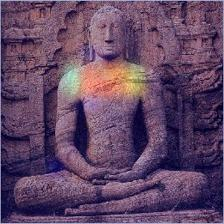

'with respect to neuron corresponding to class-"butterfly"'

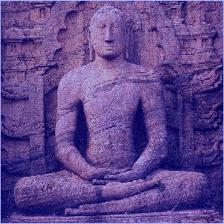

'with respect to neuron corresponding to class-"ewer"'

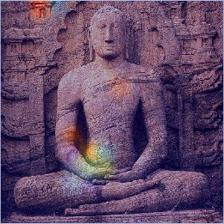

'with respect to neuron corresponding to class-"revolver"'

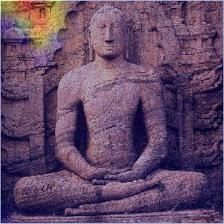

'with respect to neuron corresponding to class-"trilobite"'

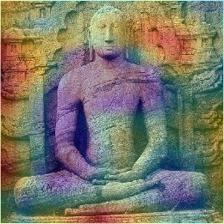

'heatmaps for butterfly class'

'with respect to neuron corresponding to class-"buddha"'

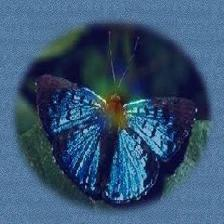

'with respect to neuron corresponding to class-"butterfly"'

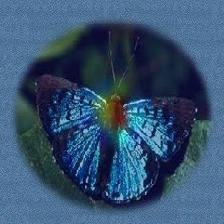

'with respect to neuron corresponding to class-"ewer"'

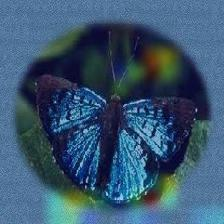

'with respect to neuron corresponding to class-"revolver"'

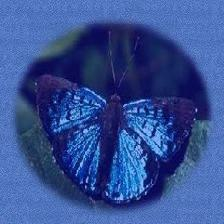

'with respect to neuron corresponding to class-"trilobite"'

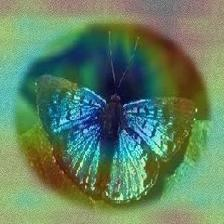

'heatmaps for ewer class'

'with respect to neuron corresponding to class-"buddha"'

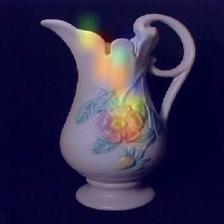

'with respect to neuron corresponding to class-"butterfly"'

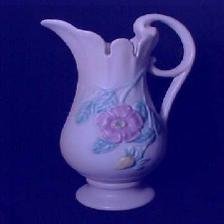

'with respect to neuron corresponding to class-"ewer"'

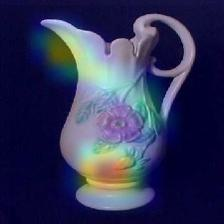

'with respect to neuron corresponding to class-"revolver"'

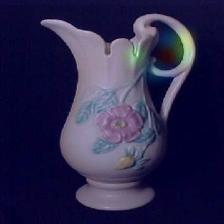

'with respect to neuron corresponding to class-"trilobite"'

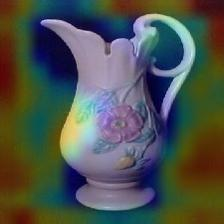

'heatmaps for revolver class'

'with respect to neuron corresponding to class-"buddha"'

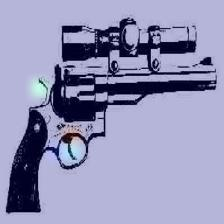

'with respect to neuron corresponding to class-"butterfly"'

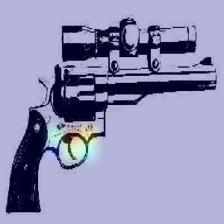

'with respect to neuron corresponding to class-"ewer"'

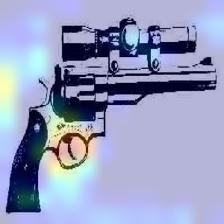

'with respect to neuron corresponding to class-"revolver"'

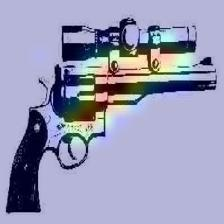

'with respect to neuron corresponding to class-"trilobite"'

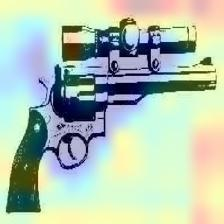

'heatmaps for trilobite class'

'with respect to neuron corresponding to class-"buddha"'

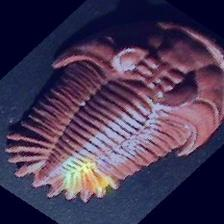

'with respect to neuron corresponding to class-"butterfly"'

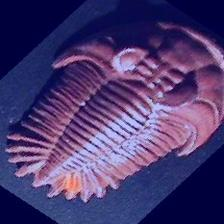

'with respect to neuron corresponding to class-"ewer"'

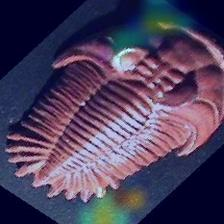

'with respect to neuron corresponding to class-"revolver"'

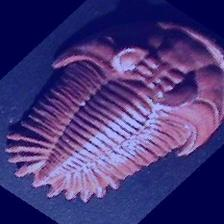

'with respect to neuron corresponding to class-"trilobite"'

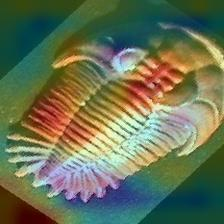

In [14]:
for class_name in class_names:    
    display(f'heatmaps for {class_name} class')
    img = PILImage.open(os.path.join(f"/kaggle/input/cs671-assignment5/Group_18/train/{class_name}", os.listdir(f"/kaggle/input/cs671-assignment5/Group_18/train/{class_name}")[0]))
    if img.mode != 'RGB':
        img = img.convert("RGB")
    img = img.resize((224,224))
    img = np.asarray(img)
    # img_normalized = tf.keras.applications.vgg19.preprocess_input(img) 
    img_normalized = img / 255
    img_array = np.expand_dims(img_normalized, axis=0)
    last_conv_layer_name = 'block5_conv4'

    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    # save_and_display_gradcam(img, heatmap)

    heatmaps = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    i = 0
    for heatmap in heatmaps:
        display(f'with respect to neuron corresponding to class-"{class_names[i]}"')
        save_and_display_gradcam(img, heatmap)
        i += 1
# plt.imshow(heatmap)


20
/kaggle/input/cs671-assignment5/Group_18/train/buddha/image_0073.jpg
(224, 224, 3)
1/1 [==============================] - 0s 201ms/step
(0, 0) (165, 181)


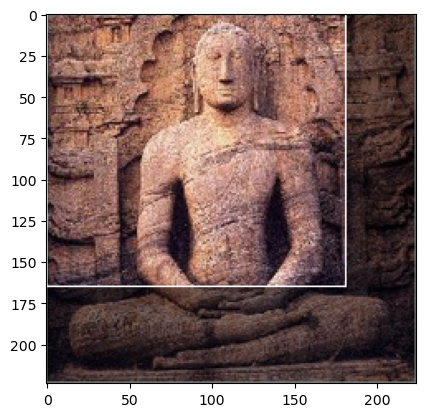

/kaggle/input/cs671-assignment5/Group_18/train/butterfly/image_0020.jpg
(224, 224, 3)
1/1 [==============================] - 0s 24ms/step
(0, 0) (224, 197)


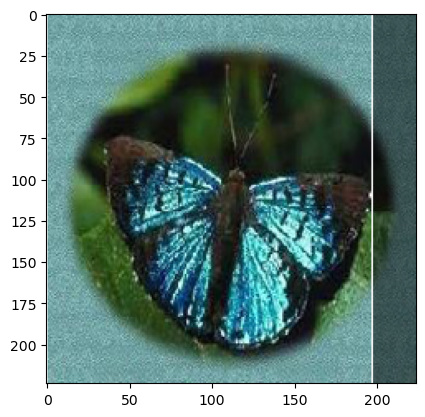

/kaggle/input/cs671-assignment5/Group_18/train/ewer/image_0073.jpg
(224, 224, 3)
1/1 [==============================] - 0s 22ms/step
(0, 42) (197, 224)


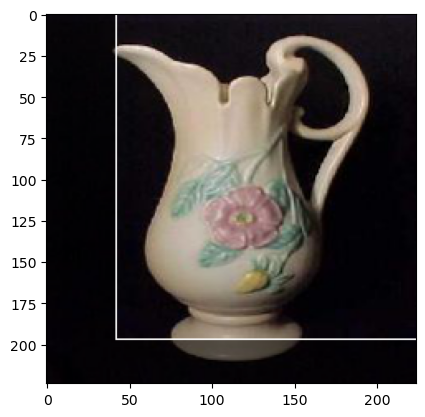

/kaggle/input/cs671-assignment5/Group_18/train/revolver/image_0040.jpg
(224, 224, 3)
1/1 [==============================] - 0s 38ms/step
(0, 0) (224, 213)


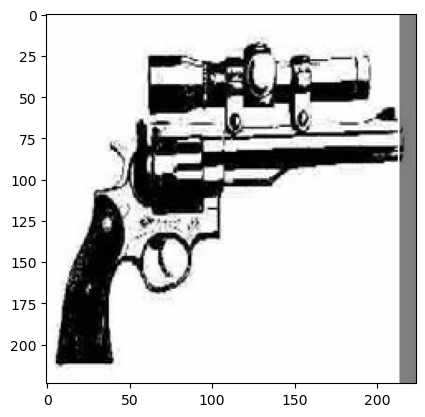

/kaggle/input/cs671-assignment5/Group_18/train/trilobite/image_0073.jpg
(224, 224, 3)
1/1 [==============================] - 0s 31ms/step
(10, 0) (224, 197)


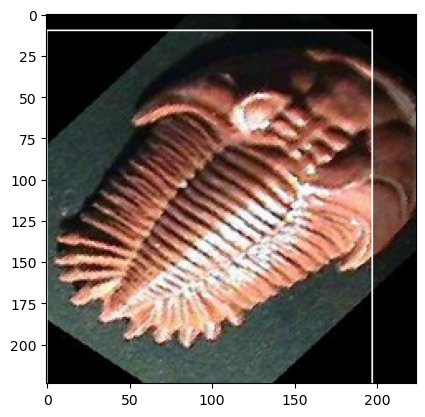

In [15]:
# input patch corresponding to maximally activated neuron in the last convolution layer:
def find_last_conv_layer(model):
    l = 0
    i = 1
    for layer in model.layers:
        if isinstance(layer, Conv2D):
            i = l
        l += 1
    return i
find_last_conv_layer(my_model)
print(find_last_conv_layer(my_model))          
def find_max(arr):
    return np.unravel_index(np.argmax(arr), arr.shape)[1:-1]
def trace(left_idx, right_idx, layer_idx, model):
    top_left = left_idx
    bottom_right = right_idx
    for i in range(layer_idx, 0, -1):
        layer = model.layers[i]
        c = layer.kernel_size[0] if isinstance(model.layers[i], Conv2D) else layer.pool_size[0]
        s = layer.strides[0]
        l_i, l_j = top_left
        r_i, r_j = bottom_right
        if layer.padding == 'same':
            p = c // 2
            top_left = max(0, s * l_i - p), max(0, s * l_j - p)
            bottom_right = min(s * r_i + (c-1) - p, layer.output.shape[1]) , min(s * r_j + (c-1) - p, layer.output.shape[2])
        else:
            top_left = s * l_i, s * l_j
            bottom_right = s * r_i + (c-1), s * r_j + (c-1)
    
    return top_left, bottom_right

last_layer = find_last_conv_layer(my_model)
new_model = Model(inputs = model.input, outputs = model.layers[last_layer].output)
# fig, axes = plt.subplots(nrows = 5, ncols = 1)\
# new_model.summary()
images = []
for a, class_name in enumerate(class_names):
    img = PILImage.open(os.path.join(f"/kaggle/input/cs671-assignment5/Group_18/train/{class_name}", os.listdir(f"/kaggle/input/cs671-assignment5/Group_18/train/{class_name}")[0]))
    if img.mode != 'RGB':
        img = img.convert("RGB")
    img = img.resize((224,224))
    img = np.asarray(img)
    img_normalized = tf.keras.applications.vgg19.preprocess_input(img)  
    print(os.path.join(f"/kaggle/input/cs671-assignment5/Group_18/train/{class_name}", os.listdir(f"/kaggle/input/cs671-assignment5/Group_18/train/{class_name}")[0]))
    print(img_normalized.shape)
    output = new_model.predict(np.array([img_normalized]))
    mx_neuron = find_max(output)
    left_idx, right_idx = trace(mx_neuron, mx_neuron, last_layer, new_model)
    print(left_idx, right_idx)
    cropped_img = img.copy()
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            l_i, l_j = left_idx
            r_i, r_j = right_idx
            if(i < l_i or j < l_j or i > r_i or j > r_j):
                cropped_img[i,j,:] //=2
            elif(i == l_i or i == r_i or j == l_j or j == r_j):
                cropped_img[i,j,:] = 255
    plt.imshow(cropped_img)
    plt.show()